In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from environments.base_env import HomeostaticEnvironment
from environments.anticipatory_env import AnticipatoryEnvironment
from models.qlearning import QLearning
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import torch

# Experience Anticipation avec QLearning 

In [3]:
# Paramètres

state_size = None  # Nombre d'états possibles mais pas nécéssaire car Q_table custom
action_size = None # Nombre d'actions possibles mais les actions possible sont different selon les etats
alpha = 0.2 # Taux d'apprentissage
gamma = 0.96 # Discount factor
epsilon = 0.1 # Facteur d'exploration
max_epoch = 15  # Nombre d'épisodes
nb_agents = 500 # Nombre d'agents

In [4]:
# Creation de l'agent

Q_table = {
    0: np.zeros(2),  # Etat initial avec 2 actions qui sont anticiper et ne pas anticiper
    1: np.zeros(1),  # Etat ou l'agent a anticipé
    2: np.zeros(1),  # Etat ou l'agent n'a pas anticipé
    3: np.zeros(1),  # Etat terminal
}

Q_table[0][0] = 1 # L'agent ne sait pas anticiper donc au début il devrait choisir de ne pas anticiper

# Instancier le modèle Q-learning
agent = QLearning(state_size=state_size, action_size=action_size, alpha=alpha, gamma=gamma, epsilon=epsilon, q_table=Q_table)


In [5]:
# Définition des paramètres de l'environnement

initial_state = torch.tensor([0.0])  # Température corporelle initiale
setpoints = torch.tensor([0.0])  # Température optimale
weights = torch.tensor([1.0])  # Importance de la température
exponents = [2, 4]  # Non-linéarité / Parametres de drive
effects = {
    # Pas d'effet sur la température de maniere flat, donc gestion dans specifique l'environnment
}
signal_timesteps = [0]
injection_timesteps = [2]
max_timestep = 24 # 30 minutes = 0.5 timestep, ==> 24 heures = 24 timesteps

# Instanciation de l'environnement
env = AnticipatoryEnvironment(
    H=initial_state,
    setpoints=setpoints,
    weights=weights,
    exponents=exponents,
    effects=effects,
    signal_timesteps=signal_timesteps,
    injection_timesteps=injection_timesteps,
    max_timestep=max_timestep
)


In [6]:
# Boucle Q-learning pour apprendre 500 agents
# Liste des agents

nb_agents = 50 # override

agents = []

for i in range(nb_agents):
    agent = QLearning(state_size=state_size, action_size=action_size, alpha=alpha, gamma=gamma, epsilon=epsilon, q_table=Q_table)
    agents.append(agent)

# Etat temporel des Q-tables de chaque agent sur chaque epoch
q_table_state = [[] for _ in range(max_epoch)]
q_table_state[0] = [agent.q_table[0].copy() for agent in agents] # Etat initial

# Etat interne des agents pour chaque epoch
internal_states = [[[] for _ in range(nb_agents)] for _ in range(max_epoch)]

env.reset()

for epoch in tqdm.tqdm(range(max_epoch), leave=True, position=0, desc="Epoch"):
    for i, agent in enumerate(agents):
        internal_state, markov_state, current_timestep = env.reset()
        done = False
        total_reward = 0
        while not done:
            action = agent.choose_action(markov_state)
            internal_state, reward, done, next_markov_state, current_timestep  = env.step(action)
            agent.update_q_value(markov_state, action, reward, next_markov_state)
            markov_state = next_markov_state
            total_reward += reward
            if current_timestep < 2.5: # timestep_important = [0.5, 1.0, 1.5, 2.0]
                internal_states[epoch][i].append(internal_state)
        q_table_state[epoch].append(agent.q_table[0].copy())


Epoch: 100%|██████████| 15/15 [00:12<00:00,  1.20it/s]


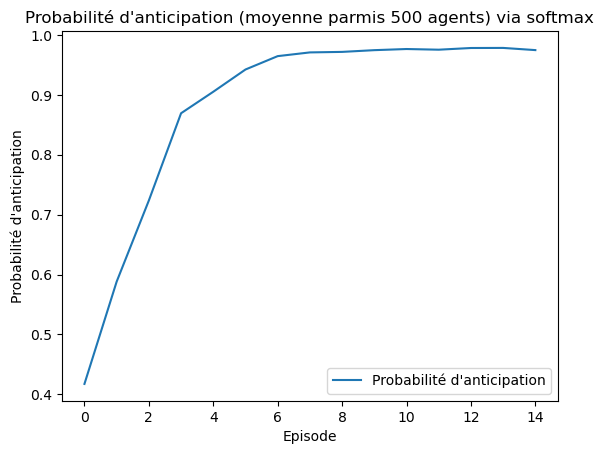

In [7]:
# Evolution des probabilités de choisir une action anticipée

anticipates = []
for epoch, q_values in enumerate(q_table_state):
    # softmax
    exp_q_values = np.exp(q_values)
    probas = exp_q_values.copy()
    for i in range(len(exp_q_values)):
        probas[i] = exp_q_values[i] / np.sum(exp_q_values[i])
    anticipates.append(probas.mean(axis=0)[1])

plt.plot(anticipates, label="Probabilité d'anticipation")
plt.title("Probabilité d'anticipation (moyenne parmis 500 agents) via softmax")
plt.xlabel("Episode")
plt.ylabel("Probabilité d'anticipation")
plt.legend()
plt.savefig("./figs/anticipate/anticipate_proba_softmax.pdf")
plt.show()


In [8]:
print(internal_states[1][1])

[tensor([0.]), tensor([0.3128]), tensor([0.4880]), tensor([-0.4158])]


ValueError: x and y can be no greater than 2D, but have shapes (15,) and (15, 4, 1)

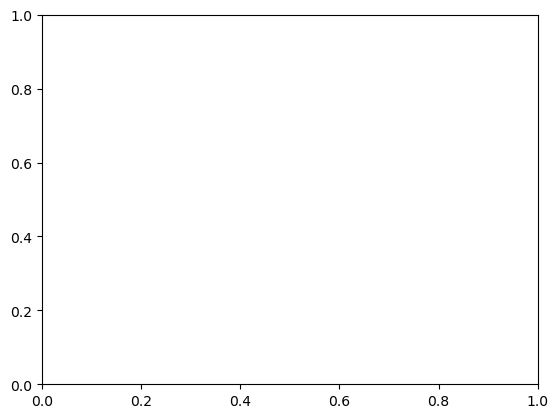

In [15]:
avg_internal_state = [[0, 0, 0, 0] for _ in range(max_epoch)]
for i in range(max_epoch):
    for j in range(nb_agents):
        avg_internal_state[i][0] += internal_states[i][j][0]
        avg_internal_state[i][1] += internal_states[i][j][1]
        avg_internal_state[i][2] += internal_states[i][j][2]
        avg_internal_state[i][3] += internal_states[i][j][3]
    avg_internal_state[i][0] /= 500
    avg_internal_state[i][1] /= 500
    avg_internal_state[i][2] /= 500
    avg_internal_state[i][3] /= 500
    
plt.plot(avg_internal_state)

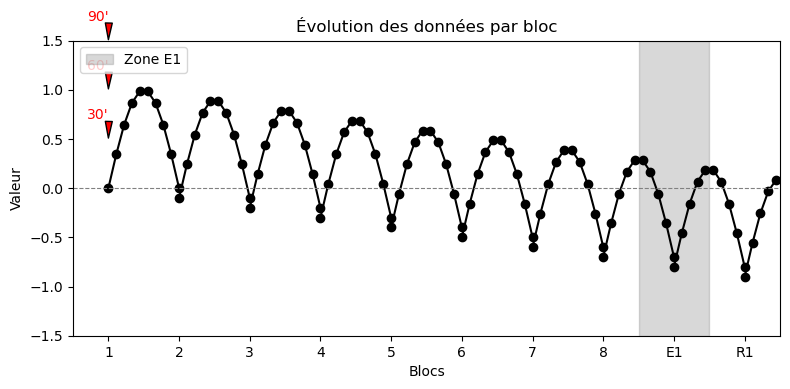

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Exemple de données simulées
blocks = ['1', '2', '3', '4', '5', '6', '7', '8', 'E1', 'R1']  # Les blocs
data = [np.sin(np.linspace(0, np.pi, 10)) - 0.1 * i for i in range(len(blocks))]  # Simuler des courbes différentes

# Création de la figure
fig, ax = plt.subplots(figsize=(8, 4))

# Ajout des segments pour chaque bloc
for i, block in enumerate(blocks):
    x = np.linspace(i + 1, i + 2, len(data[i]))  # Espacement sur l'axe X pour chaque bloc
    y = data[i]
    ax.plot(x, y, 'o-', color='black')  # Trace chaque segment
    if i == 0:  # Exemple d'annotations avec flèches
        for j, offset in enumerate([0.5, 1, 1.5, 2]):
            ax.annotate(f"{30 * (j + 1)}'",
                        xy=(x[0], y[0] + offset),
                        xytext=(x[0] - 0.3, y[0] + offset + 0.2),
                        arrowprops=dict(facecolor='red', shrink=0.05, width=1, headwidth=5),
                        color='red')

# Ajout d'une zone ombrée pour E1
ax.axvspan(8.5, 9.5, color='gray', alpha=0.3, label="Zone E1")

# Personnalisation de l'axe X
ax.set_xticks(range(1, len(blocks) + 1))
ax.set_xticklabels(blocks)

# Lignes de base
ax.axhline(0, color='gray', linestyle='--', linewidth=0.8)

# Ajustement des limites
ax.set_ylim(-1.5, 1.5)
ax.set_xlim(0.5, len(blocks) + 0.5)

# Légendes et titre
ax.set_title("Évolution des données par bloc")
ax.set_xlabel("Blocs")
ax.set_ylabel("Valeur")
ax.legend(loc='upper left')

# Affichage
plt.tight_layout()
plt.show()


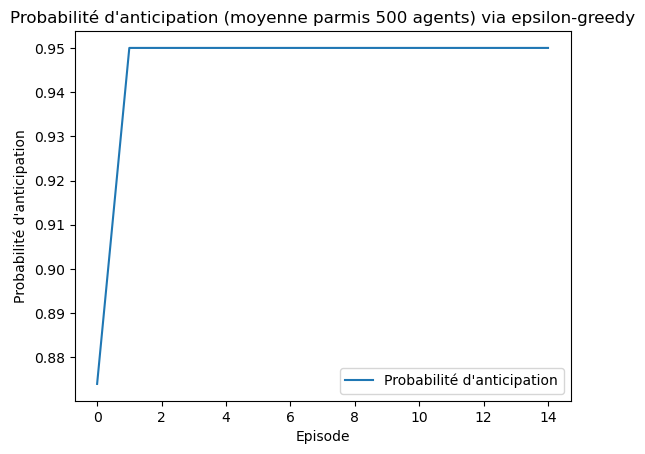

In [17]:
# Evolution des probabilités de choisir une action anticipée

anticipates = []
for epoch, q_values in enumerate(q_table_state):
    # epsilon greedy
    P = 0
    for i in range(len(q_values)):
        # Si classe dominante
        if np.argmax(q_values[i]) == 1:
            P += (1 - epsilon/2)
        else:
            P += epsilon/2
    anticipates.append(P / nb_agents)

plt.plot(anticipates, label="Probabilité d'anticipation")
plt.title("Probabilité d'anticipation (moyenne parmis 500 agents) via epsilon-greedy")
plt.xlabel("Episode")
plt.ylabel("Probabilité d'anticipation")
plt.legend()
plt.savefig("./figs/anticipate/anticipate_proba_egreedy.pdf")
plt.show()
